In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
tf.__version__

'2.1.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [108]:
segment_speeds = pd.read_csv("data/segment data/226255131.csv", sep=";")

In [117]:
segment_speeds = segment_speeds[48:]

In [121]:
pd.to_datetime(segment_speeds['StartTime'], format="%Y-%m-%d %H:%M:%S")

AttributeError: 'Series' object has no attribute 'hour'

In [113]:
segment_speeds.StartTime

48       2019-06-04 00:00:00
49       2019-06-04 00:30:00
50       2019-06-04 01:00:00
51       2019-06-04 01:30:00
52       2019-06-04 02:00:00
                ...         
43147    2021-11-22 21:30:00
43148    2021-11-22 22:00:00
43149    2021-11-22 22:30:00
43150    2021-11-22 23:00:00
43151    2021-11-22 23:30:00
Name: StartTime, Length: 43104, dtype: object

In [110]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed
48,226255131,2019-06-04 00:00:00,2019-06-04 00:30:00,90.966667
49,226255131,2019-06-04 00:30:00,2019-06-04 01:00:00,91.800000
50,226255131,2019-06-04 01:00:00,2019-06-04 01:30:00,92.000000
51,226255131,2019-06-04 01:30:00,2019-06-04 02:00:00,92.000000
52,226255131,2019-06-04 02:00:00,2019-06-04 02:30:00,92.000000


In [101]:
segment_speeds = segment_speeds.interpolate(method='linear', limit_direction='forward', axis=0)

In [102]:
pd.isnull(segment_speeds).values.sum()

0

In [8]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed
16,226255131,2019-06-03 08:00:00,2019-06-03 08:30:00,89.000000
17,226255131,2019-06-03 08:30:00,2019-06-03 09:00:00,97.900000
18,226255131,2019-06-03 09:00:00,2019-06-03 09:30:00,94.933333
19,226255131,2019-06-03 09:30:00,2019-06-03 10:00:00,92.000000
20,226255131,2019-06-03 10:00:00,2019-06-03 10:30:00,102.633333


<AxesSubplot:>

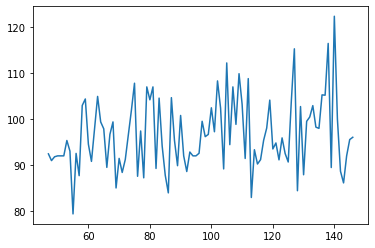

In [103]:
segment_speeds['Speed'][0:100].plot()

In [60]:
target_names = ['Speed']

We can see all of these anormalities which are things we most likely wont be able to predict as good enough by not including the event data

In [104]:
# Normally we would want to have 48 shift_steps here because 30min = 0.5h and then 0.5*48 = 24 which would cover each day.
# but in our data there are no measurements from 00:00 to 08:00 so we dropped those. This means we get shift step of 
# 16h => 32 of 30min steps

shift_steps_of_30_min = 48

In [11]:
segment_speeds_targets = segment_speeds[['Speed']].shift(-shift_steps_of_30_min)

In [12]:
segment_speeds_targets.head(25)

,Speed
16,90.966667
17,91.800000
18,92.000000
19,92.000000
20,92.000000
21,95.333333
22,93.033333
23,79.400000
24,92.533333
25,87.700000


In [13]:
x_data = segment_speeds[['Speed']].values[0:-shift_steps_of_30_min]

In [14]:
x_data.shape

(42791, 1)

In [15]:
y_data = segment_speeds_targets.values[:-shift_steps_of_30_min]

In [16]:
y_data.shape

(42791, 1)

In [17]:
num_data = len(x_data)
num_data

42791

In [18]:
train_split = 0.9

In [19]:
num_train = int(train_split * num_data)
num_train

38511

In [20]:
num_test = num_data - num_train
num_test

4280

In [21]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

42791

In [22]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

42791

In [23]:
num_x_signals = x_data.shape[1]
num_x_signals

1

In [24]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [25]:
print("Min:", np.min(segment_speeds['Speed']))
print("Max:", np.max(segment_speeds['Speed']))

Min: 6.133333333333334
Max: 137.0


In [26]:
x_scaler = MinMaxScaler()

In [27]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [28]:
x_test_scaled = x_scaler.transform(x_test)

In [29]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 0.9999999999999998


In [30]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [31]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(38511, 1)
(38511, 1)


In [32]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [33]:
batch_size = 64

In [34]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [35]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [36]:
x_batch, y_batch = next(generator)

In [37]:
print(x_batch.shape)
print(y_batch.shape)

(64, 1344, 1)
(64, 1344, 1)


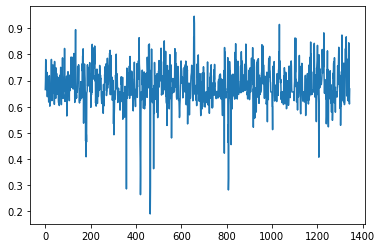

In [38]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [39]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Creation of Model

In [40]:
model = Sequential()

In [41]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [42]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [43]:
warmup_steps = 50

In [44]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [45]:
optimizer = RMSprop(lr=1e-3)

In [46]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         791040    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [48]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [49]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [50]:
callback_tensorboard = TensorBoard(log_dir=".\\23_logs\\",
                                   histogram_freq=0,
                                   write_graph=False)

In [51]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [52]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [63]:
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 100 steps, validate on 1 samples
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00001: val_loss did not improve from 0.00444
100/100 [==============================] - 27s 269ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00002: val_loss did not improve from 0.00444
100/100 [==============================] - 27s 271ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00003: val_loss did not improve from 0.00444
100/100 [==============================] - 27s 272ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00004: val_loss improved from 0.00444 to 0.00444, saving model to 23_checkpoint.keras
100/100 [==============================] - 27s 272ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 5

In [64]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
'str' object has no attribute 'decode'


In [65]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 116ms/sample - loss: 0.0045


In [66]:
print("loss (test-set):", result)

loss (test-set): 0.004452765919268131


In [67]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

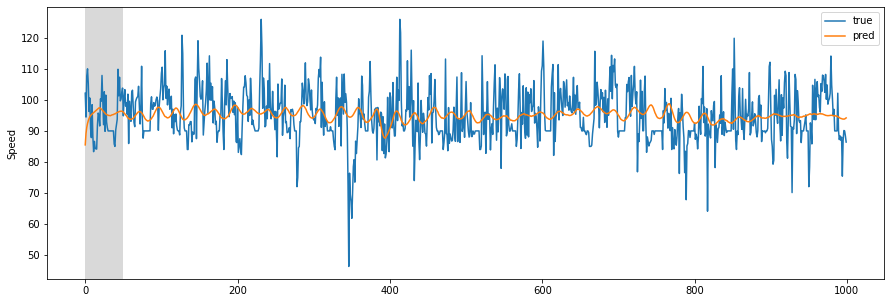

In [68]:
plot_comparison(start_idx=10000, length=1000, train=True)

In [ ]:
plot_comparison(start_idx=200000, length=1000, train=True)